# **Neuropolis: Building an artificial intelligence system for human brain activity prediction (EEG, fMRI)**

#### Version: 10th March 2024

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through nine Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

***03: Linear Regression***

*04: KNN, Decision Trees, Random Forests, SVM*

*05: Neural Networks*

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

*09: Human Brain Predictability Map*

==============================================================================================

### Notebook 03

# **Linear Regression**

## **1. Linear Regression**

- **Models**: We train a series of linear regression models, using the EEG data to predict the fMRI data. Our objective is to minimize the regression Mean Squared Error (MSE). 

- **Strategy**: For each subject, we use the eegfmriNF condition as the train set, and the fmriNF condition as the test set. We explore different sequence lengths, i.e., we use a variable number of EEG time points to predict a single subsequent fMRI time point. We also compare the Power Spectral Density (PSD) using the Welch method, the PSD using the multitaper method, the bandpowers, and the normalized bandpowers. 

- **Results**: For small sequence lengths, the accuracy of the predictions remains far from the baseline, while for larger sequence lengths, it tends to reach baseline level. Despite a high variability among subjects, a sequence length of 5 scans seems like a reasonable trade-off, since the increase in accuracy tends to slow down for higher numbers of scans. No features set beats the baseline, but the normalized bandpowers achieve the best result. 

- **Rationale**: Furthermore, a sequence length of 5 scans corresponds to 10 seconds, a duration that encompasses the peak of the Hemodynamic Response Function (HRF). In other words, we may expect that any event eliciting a peak in the BOLD signal would have happened in the 10 seconds preceding this peak. Therefore, by choosing a sequence length of 5 scans, we improve our chances of capturing, in the EEG data, a trace of the events that influence the fMRI data. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.base import clone
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [2]:
# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis_preprocessed_data/'

In [3]:
# Load the features, the targets and the baseline. 
with open(preprocessed_data_path + 'features/dict_features_welch_psd.p', 'rb') as file:
    dict_features_welch_psd = pickle.load(file)
with open(preprocessed_data_path + 'features/dict_features_multitaper_psd.p', 'rb') as file:
    dict_features_multitaper_psd = pickle.load(file)
with open(preprocessed_data_path + 'features/dict_features_bandpowers.p', 'rb') as file:
    dict_features_bandpowers = pickle.load(file)
with open(preprocessed_data_path + 'features/dict_features_bandpowers_normalized.p', 'rb') as file:
    dict_features_bandpowers_normalized = pickle.load(file)
with open(preprocessed_data_path + 'targets/dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'baseline/dict_baseline.p', 'rb') as file:
    dict_baseline_original = pickle.load(file)

In [4]:
# Define the list of subjects. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
print(subjects)

['sub-xp101', 'sub-xp102', 'sub-xp103', 'sub-xp104', 'sub-xp105', 'sub-xp106', 'sub-xp107', 'sub-xp108', 'sub-xp109', 'sub-xp110']


In [5]:
# Define an example subject. 
subject = subjects[0]
subject

'sub-xp101'

In [6]:
# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())
targets

['pgACC',
 'vmPFC',
 'Right FPC 1',
 'Right FPC 2',
 'Right FPC 3',
 'dACC 1',
 'dACC 2',
 'Left post-LPC',
 'Right post-LPC',
 'Left PMC 1',
 'Left PMC 2',
 'Left dorsal striatum',
 'Right dorsal striatum',
 'Left FPC',
 'Right FPC',
 'Left mid-LPC',
 'Right ventral striatum']

In [7]:
# Retrieve and display the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF'][targets[0]].shape[0]
nb_scans_total

200

In [8]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [9]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [10]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [11]:
# Define a function to run a linear regression model. 
def run_linear_model(LinearModel, dict_features, sequence_lengths):

    # Define dictionaries. 
    dict_models = dict()
    dict_predictions = dict()
    dict_baseline = dict()
    dict_summary = dict()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Define the general features arrays by stacking all the EEG channels. 
        X_tr_basis = np.vstack(dict_features[subject]['eegfmriNF']).transpose()
        X_te_basis = np.vstack(dict_features[subject]['fmriNF']).transpose()

        # Define the general targets arrays. 
        Y_tr_basis = np.zeros((nb_scans_total, len(targets)))
        Y_te_basis = np.zeros((nb_scans_total, len(targets)))
        for target_index in range(len(targets)):
            Y_tr_basis[:, target_index] = dict_targets[subject]['eegfmriNF'][targets[target_index]]
            Y_te_basis[:, target_index] = dict_targets[subject]['fmriNF'][targets[target_index]]
        
        # Define the general baseline array. 
        Baseline_basis = np.zeros((nb_scans_total, len(targets)))
        for target_index in range(len(targets)):
            Baseline_basis[:, target_index] = dict_baseline_original[subject]['eegfmriNF'][targets[target_index]]

        # Define the subject dictionaries and the summary DataFrame. 
        dict_models[subject] = dict()
        dict_predictions[subject] = dict()
        dict_baseline[subject] = dict()
        df_summary = pd.DataFrame()

        # Iterate through all sequence lengths. 
        for sequence_length in sequence_lengths:

            # Define the particular features arrays. 
            X_tr = np.zeros((nb_scans_total - sequence_length, X_tr_basis.shape[1] * (sequence_length + 1)))
            X_te = np.zeros((nb_scans_total - sequence_length, X_te_basis.shape[1] * (sequence_length + 1)))
            for scan in range(nb_scans_total - sequence_length):
                X_tr[scan, :] = X_tr_basis[scan:(scan + sequence_length + 1), :].ravel()
                X_te[scan, :] = X_te_basis[scan:(scan + sequence_length + 1), :].ravel()

            # Define the particular targets arrays. 
            Y_tr = Y_tr_basis[sequence_length:, :]
            Y_te = Y_te_basis[sequence_length:, :]

            # Define the particular baseline array. 
            Baseline = Baseline_basis[sequence_length:, :]

            # Clone the Scikit-Learn estimator. 
            PredictorBrain = clone(LinearModel())

            # Train the model. 
            PredictorBrain.fit(X_tr, Y_tr)

            # Predict the target values. 
            Y_pred = PredictorBrain.predict(X_te)

            # Evaluate the performance metrics. 
            mse_baseline = MSE(Y_te, Baseline)
            mae_baseline = MAE(Y_te, Baseline)
            rss_baseline = RSS(Y_te, Baseline)
            mse_model = MSE(Y_te, Y_pred)
            mae_model = MAE(Y_te, Y_pred)
            rss_model = RSS(Y_te, Y_pred)
            r2_model = 1 - (rss_model / rss_baseline)

            # Store the performance metrics and the shapes of the arrays in the DataFrame. 
            df_summary.loc[sequence_length, 'mse_baseline'] = mse_baseline
            df_summary.loc[sequence_length, 'mae_baseline'] = mae_baseline
            df_summary.loc[sequence_length, 'rss_baseline'] = rss_baseline
            df_summary.loc[sequence_length, 'mse_model'] = mse_model
            df_summary.loc[sequence_length, 'mae_model'] = mae_model
            df_summary.loc[sequence_length, 'rss_model'] = rss_model
            df_summary.loc[sequence_length, 'r2_model'] = r2_model
            df_summary.loc[sequence_length, 'X_tr.shape'] = str(X_tr.shape)
            df_summary.loc[sequence_length, 'X_te.shape'] = str(X_te.shape)
            df_summary.loc[sequence_length, 'Y_tr.shape'] = str(Y_tr.shape)
            df_summary.loc[sequence_length, 'Y_te.shape'] = str(Y_te.shape)

            # Store the model, predictions and baseline in the dictionaries. 
            dict_models[subject][sequence_length] = PredictorBrain
            dict_predictions[subject][sequence_length] = Y_pred
            dict_baseline[subject][sequence_length] = Baseline
            
        # Store the summary DataFrame in the dictionary. 
        dict_summary[subject] = df_summary
    
    return dict_models, dict_predictions, dict_baseline, dict_summary

In [12]:
# Define the sequence lengths to explore. 
sequence_lengths = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40]

In [13]:
# Run the linear regression model on the PSD using the Welch method. 
_, dict_predictions_lr_welch_psd, dict_baseline_lr_welch_psd, dict_summary_lr_welch_psd = run_linear_model(LinearModel = LinearRegression, 
                                                                                                           dict_features = dict_features_welch_psd, 
                                                                                                           sequence_lengths = sequence_lengths)

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [14]:
# Run the linear regression model on the PSD using the multitaper method. 
_, dict_predictions_lr_multitaper_psd, dict_baseline_lr_multitaper_psd, dict_summary_lr_multitaper_psd = run_linear_model(LinearModel = LinearRegression, 
                                                                                                                          dict_features = dict_features_multitaper_psd, 
                                                                                                                          sequence_lengths = sequence_lengths)

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [15]:
# Run the linear regression model on the bandpowers. 
_, dict_predictions_lr_bandpowers, dict_baseline_lr_bandpowers, dict_summary_lr_bandpowers = run_linear_model(LinearModel = LinearRegression, 
                                                                                                              dict_features = dict_features_bandpowers, 
                                                                                                              sequence_lengths = sequence_lengths)

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [16]:
# Run the linear regression model on the normalized bandpowers. 
_, dict_predictions_lr_bandpowers_norm, dict_baseline_lr_bandpowers_norm, dict_summary_lr_bandpowers_norm = run_linear_model(LinearModel = LinearRegression, 
                                                                                                                             dict_features = dict_features_bandpowers_normalized, 
                                                                                                                             sequence_lengths = sequence_lengths)

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [17]:
# Display the summary DataFrame for the first subject and the PSD using the Welch method. 
df_summary = dict_summary_lr_welch_psd['sub-xp101']
print('PSD Welch: One subject')
df_summary

PSD Welch: One subject


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
0,0.911980,0.760088,3100.731229,675.566533,6.338340,2.296926e+06,-739.769206,"(200, 4914)","(200, 4914)","(200, 17)","(200, 17)"
1,0.912989,0.760779,3088.640930,267.612489,5.066745,9.053331e+05,-292.116963,"(199, 9828)","(199, 9828)","(199, 17)","(199, 17)"
2,0.914540,0.761327,3078.340427,194.185541,4.382021,6.536285e+05,-211.331465,"(198, 14742)","(198, 14742)","(198, 17)","(198, 17)"
3,0.916127,0.762159,3068.110218,126.154756,4.138207,4.224923e+05,-136.704400,"(197, 19656)","(197, 19656)","(197, 17)","(197, 17)"
4,0.917989,0.763253,3058.740560,85.873818,3.666400,2.861316e+05,-92.545548,"(196, 24570)","(196, 24570)","(196, 17)","(196, 17)"
5,0.913235,0.761400,3027.375421,64.821670,3.362112,2.148838e+05,-69.980241,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
6,0.913391,0.760998,3012.365031,48.891763,3.079962,1.612450e+05,-52.527720,"(194, 34398)","(194, 34398)","(194, 17)","(194, 17)"
7,0.914689,0.761404,3001.096023,42.071324,2.941198,1.380360e+05,-44.995201,"(193, 39312)","(193, 39312)","(193, 17)","(193, 17)"
8,0.914825,0.761596,2985.990375,34.501214,2.777391,1.126120e+05,-36.713438,"(192, 44226)","(192, 44226)","(192, 17)","(192, 17)"
9,0.915763,0.762189,2973.484033,30.735995,2.649163,9.979978e+04,-32.563246,"(191, 49140)","(191, 49140)","(191, 17)","(191, 17)"


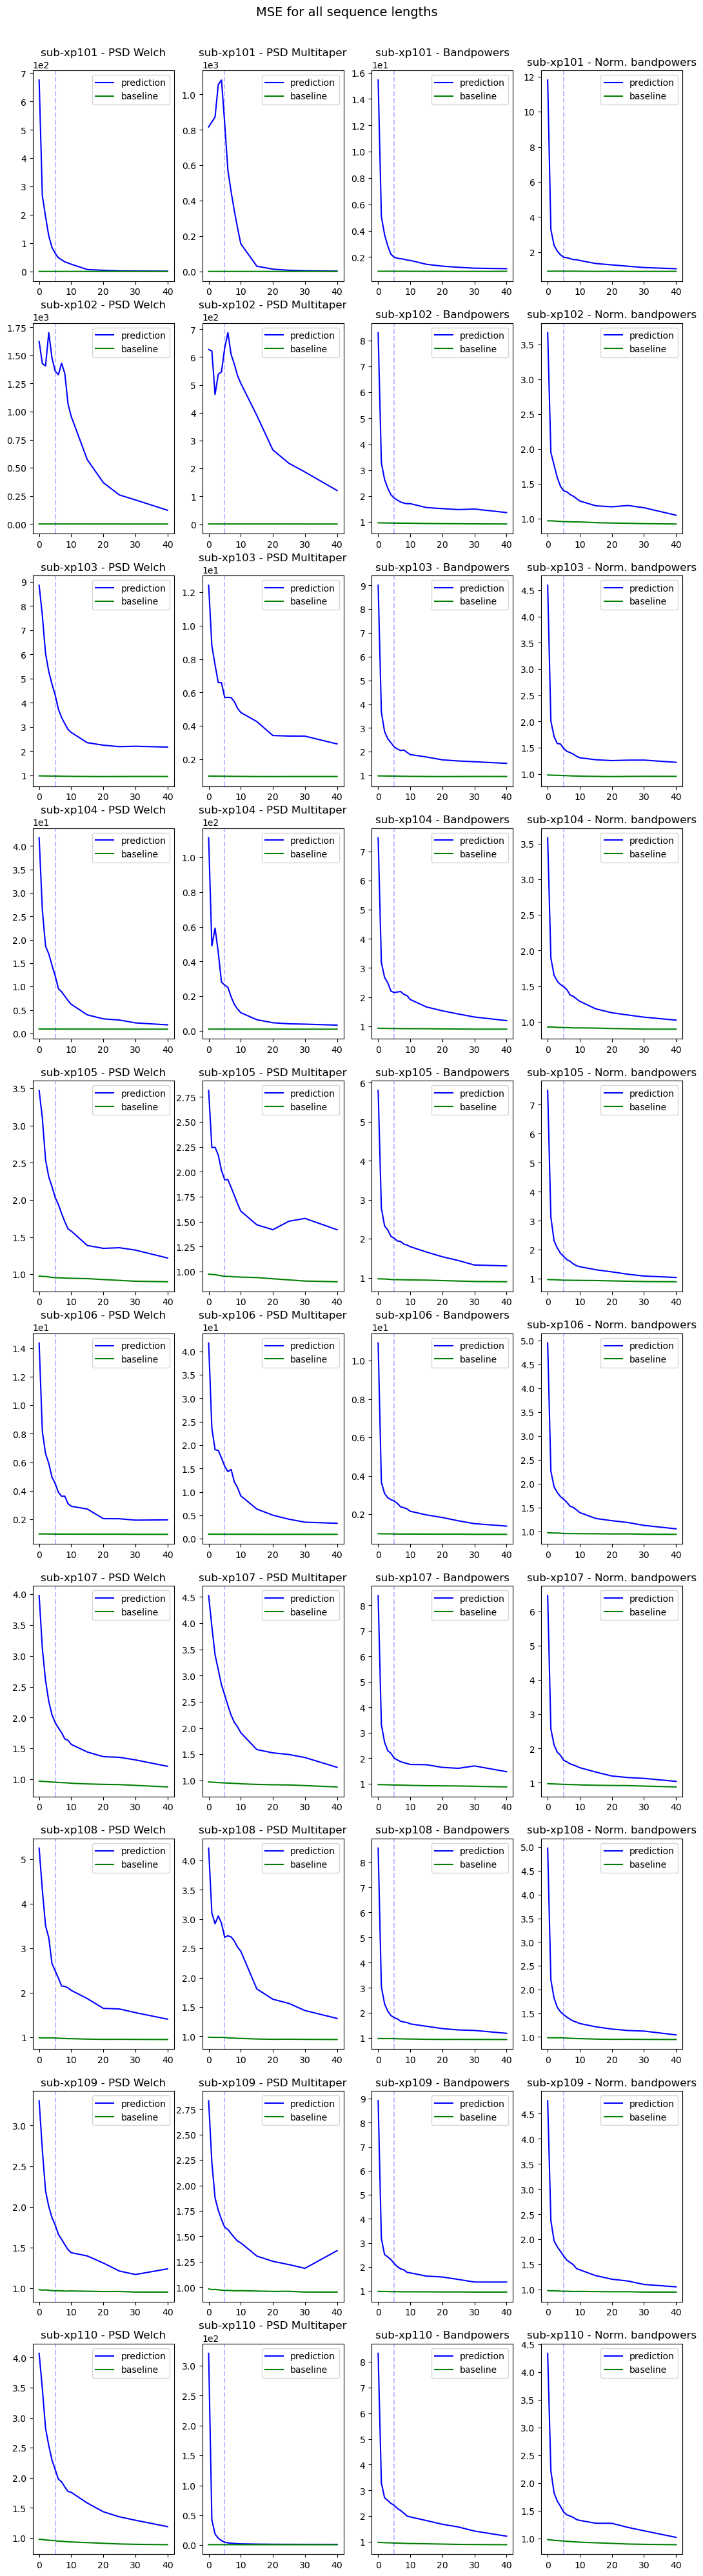

In [18]:
# Plot the Mean Squared Error (MSE) for all subjects and all EEG features sets. 
fig, axes = plt.subplots(nrows = 10, ncols = 4, figsize = (13, 50))
fig.suptitle('MSE for all sequence lengths', fontsize = 14, y = 0.9)
subject_index = 0

# Iterate through all subjects. 
for subject in subjects:    
        
    # Plot the predictions accuracy and the baseline for the PSD using the Welch method. 
    axes[subject_index, 0].plot(dict_summary_lr_welch_psd[subject]['mse_model'], c = 'blue', label = 'prediction')
    axes[subject_index, 0].plot(dict_summary_lr_welch_psd[subject]['mse_baseline'], c = 'green', label = 'baseline')
    axes[subject_index, 0].axvline(5, 0, 1, color = 'blue', linestyle = 'dashed', alpha = 0.25)
    axes[subject_index, 0].set_title(subject + ' - ' + 'PSD Welch')
    axes[subject_index, 0].legend()

    # Plot the predictions accuracy and the baseline for the PSD using the multitaper method. 
    axes[subject_index, 1].plot(dict_summary_lr_multitaper_psd[subject]['mse_model'], c = 'blue', label = 'prediction')
    axes[subject_index, 1].plot(dict_summary_lr_multitaper_psd[subject]['mse_baseline'], c = 'green', label = 'baseline')
    axes[subject_index, 1].axvline(5, 0, 1, color = 'blue', linestyle = 'dashed', alpha = 0.25)
    axes[subject_index, 1].set_title(subject + ' - ' + 'PSD Multitaper')
    axes[subject_index, 1].legend()

    # Plot the predictions accuracy and the baseline for the bandpowers. 
    axes[subject_index, 2].plot(dict_summary_lr_bandpowers[subject]['mse_model'], c = 'blue', label = 'prediction')
    axes[subject_index, 2].plot(dict_summary_lr_bandpowers[subject]['mse_baseline'], c = 'green', label = 'baseline')
    axes[subject_index, 2].axvline(5, 0, 1, color = 'blue', linestyle = 'dashed', alpha = 0.25)
    axes[subject_index, 2].set_title(subject + ' - ' + 'Bandpowers')
    axes[subject_index, 2].legend()

    # Plot the predictions accuracy and the baseline for the normalized bandpowers. 
    axes[subject_index, 3].plot(dict_summary_lr_bandpowers_norm[subject]['mse_model'], c = 'blue', label = 'prediction')
    axes[subject_index, 3].plot(dict_summary_lr_bandpowers_norm[subject]['mse_baseline'], c = 'green', label = 'baseline')
    axes[subject_index, 3].axvline(5, 0, 1, color = 'blue', linestyle = 'dashed', alpha = 0.25)
    axes[subject_index, 3].set_title(subject + ' - ' + 'Norm. bandpowers')
    axes[subject_index, 3].legend()

    # Use scientific notation for the y axis. 
    axes[subject_index, 0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
    axes[subject_index, 1].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
    axes[subject_index, 2].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))

    # Increment the subject index. 
    subject_index += 1

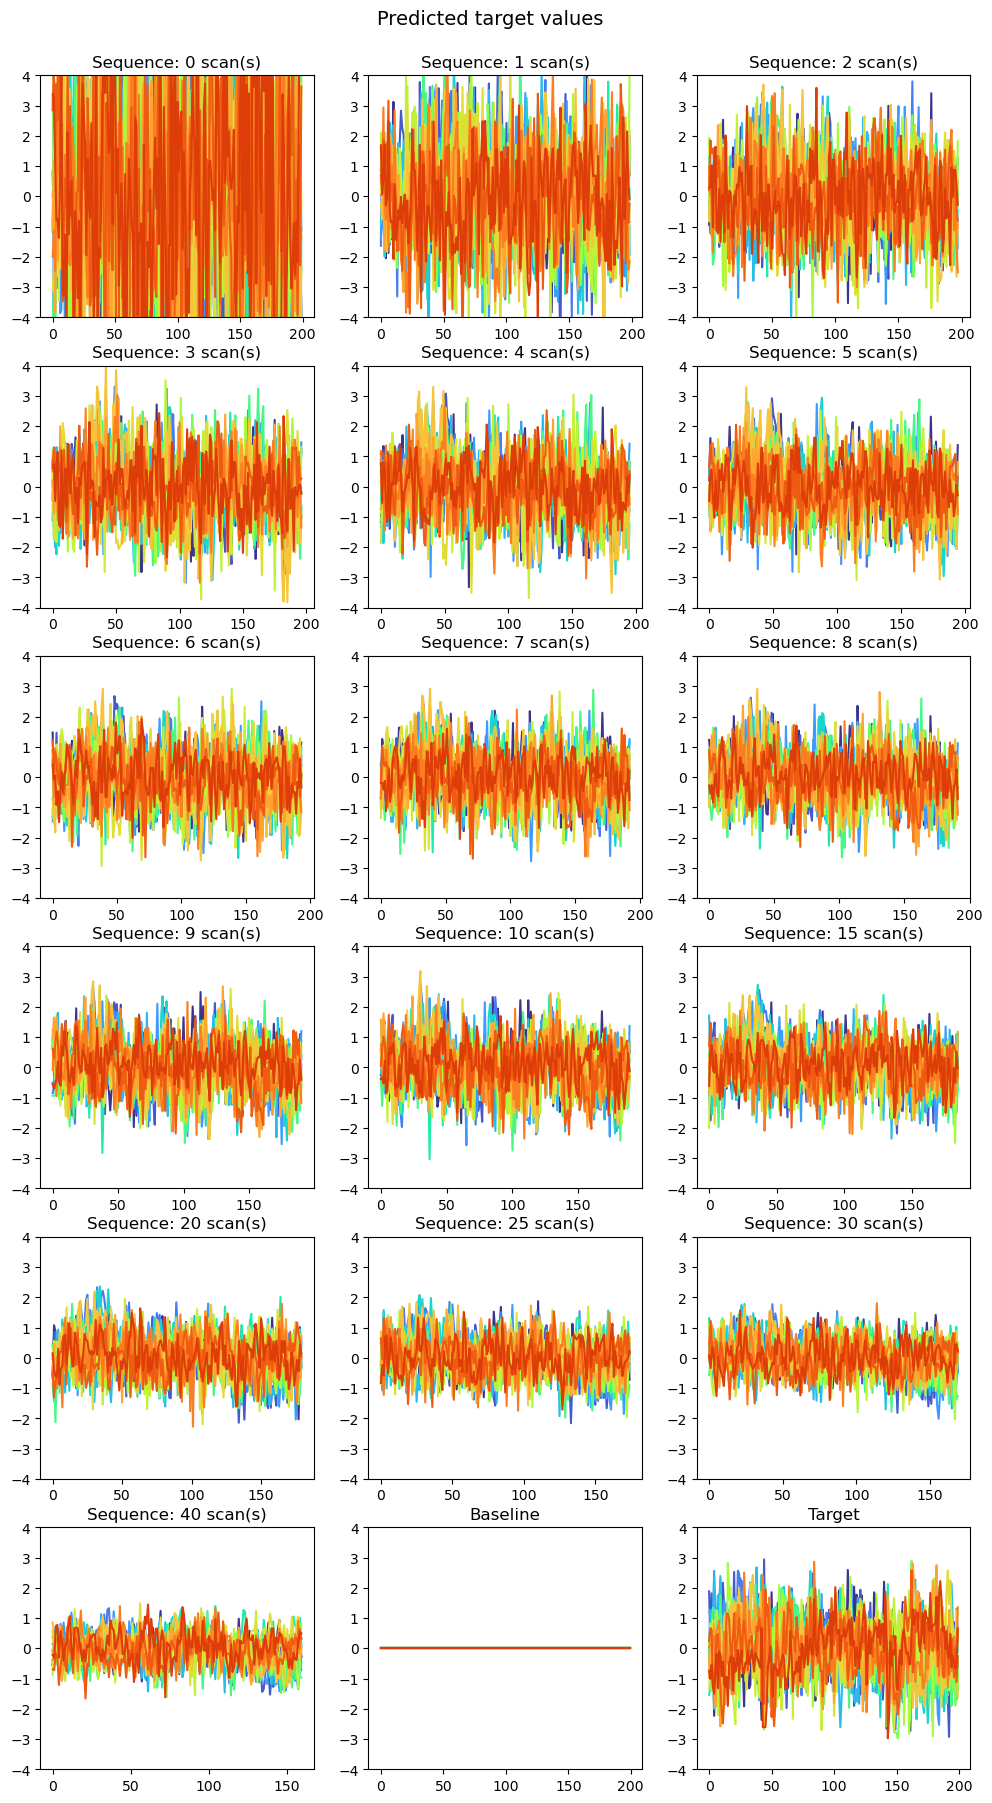

In [19]:
# Define an example subject. 
subject = subjects[0]

# Plot the predicted target for different sequence lengths. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (12, 22))
fig.suptitle('Predicted target values', fontsize = 14, y = 0.91)
sequence_length_index = 0

# Iterate through all sequence lengths. 
for sequence_length in sequence_lengths:   
    
    # Compute the row and column indexes. 
    row_index = sequence_length_index // 3
    column_index = sequence_length_index % 3

    # Iterate through all targets. 
    for target_index in range(len(targets)):
        
        # Define colormap and select a color. 
        cm = plt.colormaps['turbo']
        c = cm(0.05 * target_index + 0.05)
            
        # Plot the predicted targets. 
        axes[row_index, column_index].plot(dict_predictions_lr_bandpowers_norm[subject][sequence_length][:, target_index], color = c)
        axes[row_index, column_index].set_ylim(-4, 4)

    # Set title and increment the index. 
    axes[row_index, column_index].set_title('Sequence: ' + str(sequence_length) + ' scan(s)')
    sequence_length_index += 1

# Iterate through all targets. 
for target_index in range(len(targets)):

    # Define colormap and select a color. 
    cm = plt.colormaps['turbo']
    c = cm(0.05 * target_index + 0.05)

    # Plot the baseline. 
    axes[5, 1].plot(dict_baseline_lr_welch_psd[subject][0][:, target_index], color = c)
    axes[5, 1].set_ylim(-4, 4)

    # Plot the targets. 
    axes[5, 2].plot(dict_targets[subject]['fmriNF'][targets[target_index]], color = c)
    axes[5, 2].set_ylim(-4, 4)

# Set titles. 
axes[5, 1].set_title('Baseline')
axes[5, 2].set_title('Target');

In [20]:
# Select a sequence length. 
selected_sequence_length = 5

In [21]:
# Define a DataFrame to store the results by subject for the selected sequence length. 
def make_df_summary(dict_summary, selected_sequence_length):
    df_summary = pd.DataFrame(columns = ['mse_baseline', 'mae_baseline', 'rss_baseline', 
                                         'mse_model', 'mae_model', 'rss_model', 'r2_model', 
                                         'X_tr.shape', 'X_te.shape', 'Y_tr.shape', 'Y_te.shape'])

    # Iterate through all subjects and fill in the DataFrame. 
    for subject in subjects:
        df_summary.loc[subject, :] = dict_summary[subject].loc[selected_sequence_length, :]

    return df_summary

In [22]:
# Make a summary for the PSD using the Welch method. 
df_summary_lr_welch_psd = make_df_summary(dict_summary_lr_welch_psd, selected_sequence_length)
print('Linear Regression, PSD Welch')
df_summary_lr_welch_psd

Linear Regression, PSD Welch


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,64.82167,3.362112,214883.837088,-69.980241,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,1360.49635,8.636174,4510045.401524,-1417.96906,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,4.320519,1.543387,14322.520603,-3.450457,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,12.289933,1.80077,40741.128279,-12.360374,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,2.032642,1.087147,6738.206665,-1.134394,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,4.504883,1.199028,14933.68846,-3.690448,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,1.918564,1.090879,6360.039349,-1.012896,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,2.490454,1.196335,8255.855608,-1.540968,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,1.776597,1.065468,5889.418713,-0.83413,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,2.137236,1.153764,7084.936861,-1.241183,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"


In [23]:
# Make a summary for the PSD using the multitaper method. 
df_summary_lr_multitaper_psd = make_df_summary(dict_summary_lr_multitaper_psd, selected_sequence_length)
print('Linear Regression, PSD Multitaper')
df_summary_lr_multitaper_psd

Linear Regression, PSD Multitaper


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,836.85116,12.646718,2774161.594666,-915.358631,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,632.780647,6.781506,2097667.84552,-658.976897,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,5.696454,1.733369,18883.746384,-4.867773,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,26.366028,2.256757,87403.382279,-27.662483,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,1.920808,1.065352,6367.478983,-1.016963,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,15.486445,1.878101,51337.566632,-15.124361,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,2.630599,1.240144,8720.434587,-1.75994,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,2.689514,1.230932,8915.739788,-1.744066,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,1.589492,1.013673,5269.16692,-0.640966,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,5.077136,1.407374,16830.707475,-4.324071,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"


In [24]:
# Make a summary for the bandpowers. 
df_summary_lr_bandpowers = make_df_summary(dict_summary_lr_bandpowers, selected_sequence_length)
print('Linear Regression, Bandpowers')
df_summary_lr_bandpowers

Linear Regression, Bandpowers


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,1.986548,1.11615,6585.407152,-1.175286,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,1.925223,1.100729,6382.115893,-1.007968,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,2.203473,1.18121,7304.512358,-1.269741,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,2.155167,1.176472,7144.379384,-1.34288,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,2.012396,1.130272,6671.092281,-1.113135,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,2.678356,1.307968,8878.751607,-1.788683,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,2.003583,1.129029,6641.87778,-1.102096,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,1.814106,1.076386,6013.762302,-0.850902,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,2.140891,1.175017,7097.054662,-1.210221,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,2.419976,1.242499,8022.220028,-1.537675,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"


In [25]:
# Make a summary for the normalized bandpowers. 
df_summary_lr_bandpowers_norm = make_df_summary(dict_summary_lr_bandpowers_norm, selected_sequence_length)
print('Linear Regression, Normalized Bandpowers')
df_summary_lr_bandpowers_norm

Linear Regression, Normalized Bandpowers


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,1.706744,1.038111,5657.857282,-0.868898,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,1.398855,0.947022,4637.203047,-0.458976,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,1.48464,0.974153,4921.582993,-0.52929,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,1.492644,0.975387,4948.11336,-0.622651,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,1.76713,1.065624,5858.036912,-0.855592,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,1.678731,1.042252,5564.993216,-0.747881,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,1.652857,1.025956,5479.220601,-0.734125,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,1.468485,0.973192,4868.028875,-0.498271,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,1.667865,1.035244,5528.973303,-0.721877,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,1.474263,0.970088,4887.181135,-0.545966,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"


In [26]:
# Define a function to display the results with a bar plot. 
def display_bar_plot(df_summary_welch_psd, df_summary_multitaper_psd, df_summary_bandpowers, df_summary_bandpowers_norm, model_name):

    # Retrieve the average MAE and the standard error of the MAE. 
    mae = [df_summary_welch_psd['mae_baseline'].mean(), 
            df_summary_welch_psd['mae_model'].mean(), 
            df_summary_multitaper_psd['mae_model'].mean(), 
            df_summary_bandpowers['mae_model'].mean(), 
            df_summary_bandpowers_norm['mae_model'].mean()]
    mae_se = [np.std(df_summary_welch_psd['mae_baseline']) / np.sqrt(df_summary_welch_psd['mae_baseline'].shape[0]), 
                np.std(df_summary_welch_psd['mae_model']) / np.sqrt(df_summary_welch_psd['mae_model'].shape[0]), 
                np.std(df_summary_multitaper_psd['mae_model']) / np.sqrt(df_summary_multitaper_psd['mae_model'].shape[0]), 
                np.std(df_summary_bandpowers['mae_model']) / np.sqrt(df_summary_bandpowers['mae_model'].shape[0]), 
                np.std(df_summary_bandpowers_norm['mae_model']) / np.sqrt(df_summary_bandpowers_norm['mae_model'].shape[0]), ]

    # Display the average MAE and its standard error in a bar plot. 
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))
    axes.bar(range(5), mae, width = 0.6, color = ['green', 'blue', 'blue', 'blue', 'blue'])
    axes.errorbar(range(5), mae, yerr = mae_se, fmt = 'None', color = 'black')
    axes.axhline(mae[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
    axes.set_xticks(range(5), labels = ['Baseline', 'PSD Welch', 'PSD Multitaper', 'Bandpowers', 'Norm. Bandpowers'])
    axes.set_ylabel('Average MAE')
    axes.set_title(model_name);

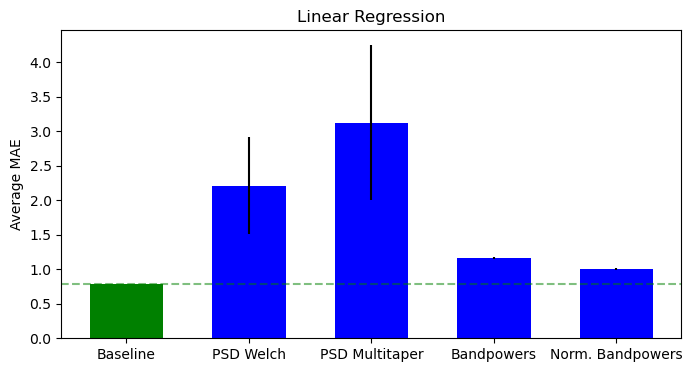

In [27]:
# Display the results with a bar plot. 
display_bar_plot(df_summary_lr_welch_psd, 
                 df_summary_lr_multitaper_psd, 
                 df_summary_lr_bandpowers, 
                 df_summary_lr_bandpowers_norm, 
                 'Linear Regression')

## **2. Ridge Regression**

- **Models**: We train a series of Ridge regression models with the selected sequence length of 5 scans. Our objective is to minimize the regression Mean Squared Error (MSE). 

- **Strategy**: Again, for each subject, we use the eegfmriNF condition as the train set, and the fmriNF condition as the test set. We also compare the results between the PSD using the Welch method, the PSD using the multitaper method, the bandpowers, and the normalized bandpowers. 

- **Results**: No features set beats the baseline, but suspiciously, the two PSD sets reach exactly the baseline level, with no noticeable standard error. By plotting the Ridge coefficients, we understand that the values of the weight vectors are shrunk to extremely low levels, which results in a flat prediction similar to the baseline. 

In [28]:
# Run the Ridge regression model on the PSD using the Welch method. 
dict_models_ridge_welch_psd, dict_predictions_ridge_welch_psd, dict_baseline_ridge_welch_psd, dict_summary_ridge_welch_psd = run_linear_model(LinearModel = Ridge, 
                                                                                                                                              dict_features = dict_features_welch_psd, 
                                                                                                                                              sequence_lengths = [selected_sequence_length])

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [29]:
# Run the Ridge regression model on the PSD using the multitaper method. 
dict_models_ridge_multitaper_psd, dict_predictions_ridge_multitaper_psd, dict_baseline_ridge_multitaper_psd, dict_summary_ridge_multitaper_psd = run_linear_model(LinearModel = Ridge, 
                                                                                                                                                                  dict_features = dict_features_multitaper_psd, 
                                                                                                                                                                  sequence_lengths = [selected_sequence_length])

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [30]:
# Run the Ridge regression model on the bandpowers. 
dict_models_ridge_bandpowers, dict_predictions_ridge_bandpowers, dict_baseline_ridge_bandpowers, dict_summary_ridge_bandpowers = run_linear_model(LinearModel = Ridge, 
                                                                                                                                                  dict_features = dict_features_bandpowers, 
                                                                                                                                                  sequence_lengths = [selected_sequence_length])

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [31]:
# Run the Ridge regression model on the normalized bandpowers. 
dict_models_ridge_bandpowers_norm, dict_predictions_ridge_bandpowers_norm, dict_baseline_ridge_bandpowers_norm, dict_summary_ridge_bandpowers_norm = run_linear_model(LinearModel = Ridge, 
                                                                                                                                                                      dict_features = dict_features_bandpowers_normalized, 
                                                                                                                                                                      sequence_lengths = [selected_sequence_length])

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [32]:
# Make a summary for the PSD using the Welch method. 
df_summary_ridge_welch_psd = make_df_summary(dict_summary_ridge_welch_psd, selected_sequence_length)
print('Ridge Regression, PSD Welch')
df_summary_ridge_welch_psd

Ridge Regression, PSD Welch


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,0.914003,0.762116,3029.920323,-0.000841,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,0.9598,0.799181,3181.735549,-0.001051,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,0.971045,0.793556,3219.014076,-0.000249,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,0.91983,0.76899,3049.235499,0.000054,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,0.952326,0.788047,3156.960456,0.000001,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,0.960237,0.792856,3183.184977,0.000209,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,0.953105,0.782774,3159.542303,0.000033,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,0.98029,0.799638,3249.660231,-0.000173,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,0.968663,0.798584,3211.117741,-0.000032,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,0.953869,0.790001,3162.075367,-0.000262,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"


In [33]:
# Make a summary for the PSD using the multitaper method. 
df_summary_ridge_multitaper_psd = make_df_summary(dict_summary_ridge_multitaper_psd, selected_sequence_length)
print('Ridge Regression, PSD Multitaper')
df_summary_ridge_multitaper_psd

Ridge Regression, PSD Multitaper


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,0.914003,0.762116,3029.920329,-0.000841,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,0.9598,0.799181,3181.735549,-0.001051,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,0.971045,0.793556,3219.014076,-0.000249,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,0.91983,0.76899,3049.235499,0.000054,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,0.952326,0.788047,3156.960456,0.000001,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,0.960237,0.792856,3183.184977,0.000209,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,0.953105,0.782774,3159.542303,0.000033,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,0.98029,0.799638,3249.660231,-0.000173,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,0.968663,0.798584,3211.117741,-0.000032,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,0.953869,0.790001,3162.075367,-0.000262,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"


In [34]:
# Make a summary for the bandpowers. 
df_summary_ridge_bandpowers = make_df_summary(dict_summary_ridge_bandpowers, selected_sequence_length)
print('Ridge Regression, Bandpowers')
df_summary_ridge_bandpowers

Ridge Regression, Bandpowers


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,1.536055,0.978553,5092.021326,-0.681992,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,1.44699,0.959898,4796.773205,-0.509181,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,1.650239,1.02735,5470.543028,-0.699869,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,1.577349,1.004001,5228.912222,-0.714735,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,1.559667,0.998433,5170.297307,-0.637743,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,1.815184,1.083304,6017.333574,-0.889954,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,1.474672,0.965665,4888.538238,-0.547179,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,1.402785,0.949173,4650.233374,-0.431238,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,1.597154,1.018308,5294.564267,-0.648875,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,1.669011,1.037332,5532.771045,-0.750186,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"


In [35]:
# Make a summary for the normalized bandpowers. 
df_summary_ridge_bandpowers_norm = make_df_summary(dict_summary_ridge_bandpowers_norm, selected_sequence_length)
print('Ridge Regression, Normalized Bandpowers')
df_summary_ridge_bandpowers_norm

Ridge Regression, Normalized Bandpowers


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,1.702347,1.036761,5643.279059,-0.864083,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,1.399244,0.946766,4638.493727,-0.459382,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,1.481884,0.973034,4912.446976,-0.526451,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,1.490668,0.97482,4941.564231,-0.620504,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,1.762063,1.064281,5841.238691,-0.850271,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,1.674707,1.040927,5551.654077,-0.743691,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,1.649187,1.024795,5467.053964,-0.730274,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,1.464232,0.972384,4853.929924,-0.493931,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,1.664965,1.03436,5519.357508,-0.718882,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,1.472567,0.969525,4881.561258,-0.544188,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"


In [36]:
# Define a DataFrame to store the Ridge coefficients. 
df_ridge_coefficients = pd.DataFrame()

# Iterate through all subjects. 
for subject in subjects:

    # Retrieve the coefficients. 
    model_welch_psd = dict_models_ridge_welch_psd[subject][selected_sequence_length]
    df_ridge_coefficients.loc[subject, 'Number of coefficients'] = model_welch_psd.coef_.shape[0] * model_welch_psd.coef_.shape[1]
    df_ridge_coefficients.loc[subject, 'Mean of the coefficients'] = model_welch_psd.coef_.mean()

# Display the DataFrame. 
df_ridge_coefficients

,Number of coefficients,Mean of the coefficients
sub-xp101,501228.0,1.658783e-09
sub-xp102,501228.0,-2.679964e-11
sub-xp103,501228.0,7.064408e-11
sub-xp104,501228.0,8.591026e-12
sub-xp105,501228.0,1.484246e-10
sub-xp106,501228.0,-1.733442e-11
sub-xp107,501228.0,-8.331343e-12
sub-xp108,501228.0,-6.957174e-13
sub-xp109,501228.0,-2.770014e-11
sub-xp110,501228.0,-2.404381e-11


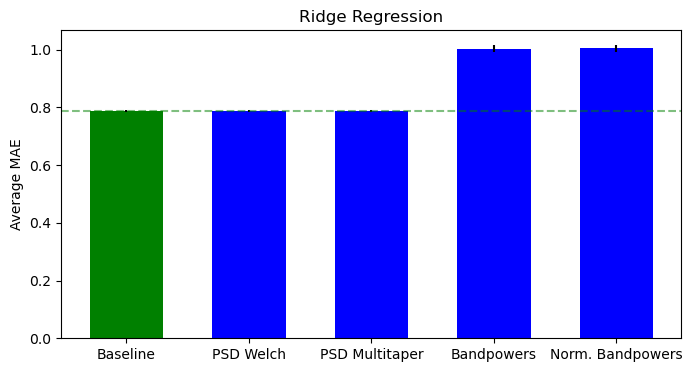

In [37]:
# Display the results with a bar plot. 
display_bar_plot(df_summary_ridge_welch_psd, 
                 df_summary_ridge_multitaper_psd, 
                 df_summary_ridge_bandpowers, 
                 df_summary_ridge_bandpowers_norm, 
                 'Ridge Regression')

## **3. Lasso Regression**

- **Models**: We train a series of Lasso regression models with the selected sequence length of 5 scans. Our objective is to minimize the regression Mean Squared Error (MSE). 

- **Strategy**: Again, for each subject, we use the eegfmriNF condition as the train set, and the fmriNF condition as the test set. We also compare the results between the PSD using the Welch method, the PSD using the multitaper method, the bandpowers, and the normalized bandpowers. 

- **Results**: No features set beats the baseline, but suspiciously, all features sets reach exactly the baseline level, with no noticeable standard error. By plotting the Lasso coefficients, we understand that all the values of the weight vectors are shrunk to zero, which results in a flat prediction similar to the baseline. Therefore, neither the Ridge regression nor the Lasso regression provide relevant results in our case, and these models cannot help us to select a features set. 

- **Next steps**: For the next machine learning and deep learning steps, we will limit ourselves to the normalized bandpowers, the features set that gives the best result in the standard linear regression. Compared with the PSD sets, an additional advantage of the normalized bandpowers is that the number of features is significantly lower. 

In [38]:
# Run the Lasso regression model on the PSD using the Welch method. 
dict_models_lasso_welch_psd, dict_predictions_lasso_welch_psd, dict_baseline_lasso_welch_psd, dict_summary_lasso_welch_psd = run_linear_model(LinearModel = Lasso, 
                                                                                                                                              dict_features = dict_features_welch_psd, 
                                                                                                                                              sequence_lengths = [selected_sequence_length])

sub-xp101


sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [39]:
# Run the Lasso regression model on the PSD using the multitaper method. 
dict_models_lasso_multitaper_psd, dict_predictions_lasso_multitaper_psd, dict_baseline_lasso_multitaper_psd, dict_summary_lasso_multitaper_psd = run_linear_model(LinearModel = Lasso, 
                                                                                                                                                                  dict_features = dict_features_multitaper_psd, 
                                                                                                                                                                  sequence_lengths = [selected_sequence_length])

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [40]:
# Run the Lasso regression model on the bandpowers. 
dict_models_lasso_bandpowers, dict_predictions_lasso_bandpowers, dict_baseline_lasso_bandpowers, dict_summary_lasso_bandpowers = run_linear_model(LinearModel = Lasso, 
                                                                                                                                                  dict_features = dict_features_bandpowers, 
                                                                                                                                                  sequence_lengths = [selected_sequence_length])

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [41]:
# Run the Lasso regression model on the normalized bandpowers. 
dict_models_lasso_bandpowers_norm, dict_predictions_lasso_bandpowers_norm, dict_baseline_lasso_bandpowers_norm, dict_summary_lasso_bandpowers_norm = run_linear_model(LinearModel = Lasso, 
                                                                                                                                                                      dict_features = dict_features_bandpowers_normalized, 
                                                                                                                                                                      sequence_lengths = [selected_sequence_length])

sub-xp101
sub-xp102
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110


In [42]:
# Make a summary for the PSD using the Welch method. 
df_summary_lasso_welch_psd = make_df_summary(dict_summary_lasso_welch_psd, selected_sequence_length)
print('Lasso Regression, PSD Welch')
df_summary_lasso_welch_psd

Lasso Regression, PSD Welch


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,0.914003,0.762116,3029.920323,-0.000841,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,0.9598,0.799181,3181.735549,-0.001051,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,0.971045,0.793556,3219.014076,-0.000249,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,0.91983,0.76899,3049.235499,0.000054,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,0.952326,0.788047,3156.960456,0.000001,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,0.960237,0.792856,3183.184977,0.000209,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,0.953105,0.782774,3159.542303,0.000033,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,0.98029,0.799638,3249.660231,-0.000173,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,0.968663,0.798584,3211.117741,-0.000032,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,0.953869,0.790001,3162.075367,-0.000262,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"


In [43]:
# Make a summary for the PSD using the multitaper method. 
df_summary_lasso_multitaper_psd = make_df_summary(dict_summary_lasso_multitaper_psd, selected_sequence_length)
print('Lasso Regression, PSD Multitaper')
df_summary_lasso_multitaper_psd

Lasso Regression, PSD Multitaper


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,0.914003,0.762116,3029.920323,-0.000841,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,0.9598,0.799181,3181.735549,-0.001051,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,0.971045,0.793556,3219.014076,-0.000249,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,0.91983,0.76899,3049.235499,0.000054,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,0.952326,0.788047,3156.960456,0.000001,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,0.960237,0.792856,3183.184977,0.000209,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,0.953105,0.782774,3159.542303,0.000033,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,0.98029,0.799638,3249.660231,-0.000173,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,0.968663,0.798584,3211.117741,-0.000032,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,0.953869,0.790001,3162.075367,-0.000262,"(195, 29484)","(195, 29484)","(195, 17)","(195, 17)"


In [44]:
# Make a summary for the bandpowers. 
df_summary_lasso_bandpowers = make_df_summary(dict_summary_lasso_bandpowers, selected_sequence_length)
print('Lasso Regression, Bandpowers')
df_summary_lasso_bandpowers

Lasso Regression, Bandpowers


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,0.914003,0.762116,3029.920323,-0.000841,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,0.9598,0.799181,3181.735549,-0.001051,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,0.971045,0.793556,3219.014076,-0.000249,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,0.91983,0.76899,3049.235499,0.000054,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,0.952326,0.788047,3156.960456,0.000001,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,0.960237,0.792856,3183.184977,0.000209,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,0.953105,0.782774,3159.542303,0.000033,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,0.98029,0.799638,3249.660231,-0.000173,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,0.968663,0.798584,3211.117741,-0.000032,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,0.953869,0.790001,3162.075367,-0.000262,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"


In [45]:
# Make a summary for the normalized bandpowers. 
df_summary_lasso_bandpowers_norm = make_df_summary(dict_summary_lasso_bandpowers_norm, selected_sequence_length)
print('Lasso Regression, Normalized Bandpowers')
df_summary_lasso_bandpowers_norm

Lasso Regression, Normalized Bandpowers


,mse_baseline,mae_baseline,rss_baseline,mse_model,mae_model,rss_model,r2_model,X_tr.shape,X_te.shape,Y_tr.shape,Y_te.shape
sub-xp101,0.913235,0.7614,3027.375421,0.914003,0.762116,3029.920323,-0.000841,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp102,0.958792,0.799623,3178.395872,0.9598,0.799181,3181.735549,-0.001051,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp103,0.970804,0.793431,3218.213652,0.971045,0.793556,3219.014076,-0.000249,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp104,0.919879,0.768766,3049.400183,0.91983,0.76899,3049.235499,0.000054,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp105,0.952327,0.788395,3156.964167,0.952326,0.788047,3156.960456,0.000001,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp106,0.960438,0.793431,3183.851143,0.960237,0.792856,3183.184977,0.000209,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp107,0.953136,0.78254,3159.64592,0.953105,0.782774,3159.542303,0.000033,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp108,0.98012,0.799883,3249.098129,0.98029,0.799638,3249.660231,-0.000173,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp109,0.968632,0.79891,3211.015629,0.968663,0.798584,3211.117741,-0.000032,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"
sub-xp110,0.953619,0.790629,3161.248042,0.953869,0.790001,3162.075367,-0.000262,"(195, 2268)","(195, 2268)","(195, 17)","(195, 17)"


In [46]:
# Define a DataFrame to store the Lasso coefficients. 
df_lasso_coefficients = pd.DataFrame()

# Iterate through all subjects. 
for subject in subjects:

    # Retrieve the coefficients. 
    model_welch_psd = dict_models_lasso_welch_psd[subject][selected_sequence_length]
    df_lasso_coefficients.loc[subject, 'Number of coefficients'] = model_welch_psd.coef_.shape[0] * model_welch_psd.coef_.shape[1]
    df_lasso_coefficients.loc[subject, 'Number of coefficients shrunk to zero'] = (model_welch_psd.coef_ == 0.0).sum()
    df_lasso_coefficients.loc[subject, 'Proportion of coefficients shrunk to zero'] = (model_welch_psd.coef_ == 0.0).sum() / (model_welch_psd.coef_.shape[0] * model_welch_psd.coef_.shape[1])

# Display the DataFrame. 
df_lasso_coefficients

,Number of coefficients,Number of coefficients shrunk to zero,Proportion of coefficients shrunk to zero
sub-xp101,501228.0,501228.0,1.0
sub-xp102,501228.0,501228.0,1.0
sub-xp103,501228.0,501228.0,1.0
sub-xp104,501228.0,501228.0,1.0
sub-xp105,501228.0,501228.0,1.0
sub-xp106,501228.0,501228.0,1.0
sub-xp107,501228.0,501228.0,1.0
sub-xp108,501228.0,501228.0,1.0
sub-xp109,501228.0,501228.0,1.0
sub-xp110,501228.0,501228.0,1.0


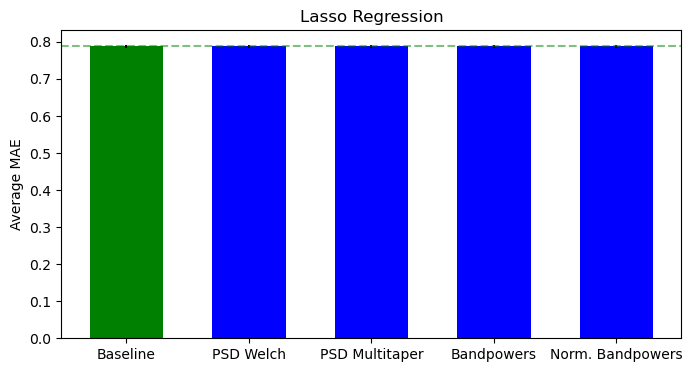

In [47]:
# Display the results with a bar plot. 
display_bar_plot(df_summary_lasso_welch_psd, 
                 df_summary_lasso_multitaper_psd, 
                 df_summary_lasso_bandpowers, 
                 df_summary_lasso_bandpowers_norm, 
                 'Lasso Regression')